In [1]:
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
import gym

In [3]:
env = gym.make("CartPole-v1")
obs = env.reset()
obs

array([ 0.00734136,  0.04384808, -0.0426318 , -0.01564195], dtype=float32)

In [4]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [5]:
env.render()

True

In [6]:
img = env.render(mode="rgb_array")
img.shape

C:\Users\cheol\anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 스레드 모드가 설정된 후에는 바꿀 수 없습니다
  warnings.warn(str(err))


(400, 600, 3)

In [7]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

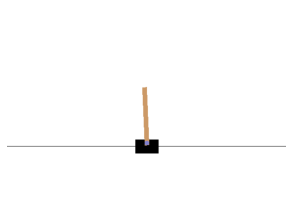

In [8]:
plot_environment(env)
plt.show()

In [9]:
env.action_space
# Discrete(2)은 가능한 행동이 정수 0과 1이라는 것을 의미
# 각각 왼쪽 가속(0)과 오른쪽 가속(1)

Discrete(2)

In [10]:
action = 1 # 오른쪽으로 가속
obs, reward, done, info = env.step(action)
obs # 새로운 관측

array([ 0.00821832,  0.23955467, -0.04294464, -0.32146508], dtype=float32)

In [11]:
reward

1.0

In [12]:
done

False

In [13]:
info

{}

### 정책 코딩
- 에피소드 500번 실행해서 얻은 평균 보상을 확인


In [34]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [42]:
env.seed(42)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [43]:
# 결과 확인

import numpy as np
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.718, 8.858356280936096, 24.0, 68.0)

- 이 정책은 막대를 쓰러뜨리지 않고 68번보다 많은 스텝을 진행하지 못함. 

In [44]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [45]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [62]:
plot_animation(frames)

# 4. 신경망 정책

In [47]:
import tensorflow as tf
from tensorflow import keras

In [48]:

n_inputs = 4

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [49]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [51]:
frames = render_policy_net(model)
plot_animation(frames)

# 정책 그레이디언트

In [63]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        #print("left_proba", left_proba)
        action = (tf.random.uniform([1, 1]) > left_proba)
        #print("action", action)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        #print("y_target :",y_target)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
        #print("loss ; ", loss)
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [64]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [65]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [66]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

In [67]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [68]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [69]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [59]:
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 149, mean rewards: 192.8

In [61]:
frames = render_policy_net(model)
plot_animation(frames)

# 마르코프 결정 과정


In [70]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to ...

n_max_steps = 50

def print_sequence():
    current_state = 0
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


In [72]:
# 
transition_probabilities = [ # shape=[s, a, s']

        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

### Q-가치 반복 알고리즘

In [73]:
Q_values = np.full((3,3), -np.inf) # 불가능한 행동에 대해서는 -np.inf

for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0 # 모든 가능한 행동에 대해서

In [74]:
#  
gamma = 0.90 # 할인 계수

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                                    for sp in range(3)])

In [75]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

예를 들어 에이전트가 상태 s0에 있고 행동 a1을 선택했을 때 할인된 미래 보상의 기대 합은 약 17.0이다

In [76]:
# 각 상태에 대해 가장 높은 Q-가치를 갖는 행동을 확인

np.argmax(Q_values, axis=1)

array([0, 0, 1], dtype=int64)

- 상태 s0에서는 행동 a0을 선택하고, 상태 s1에서는 행동 a0을 선택, 상태 s2에서는 행동 a1을 선택한다.
- 할인 계수를 0.95로 높이면 최적의 정책이 바뀜
- 즉, 상태 s1에서 최선의 행동은  a2가 됨. 이는 미래 보상에 더 가치를 둘수록 미래의 행복을 위해 당장의 고통을 견디려 하기 때문이다.

- **할인 계수 0.95**

In [77]:
Q_values = np.full((3, 3), -np.inf)

for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  
gamma = 0.95  # 할인 계수

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [78]:
np.argmax(Q_values, axis=1)


array([0, 2, 1], dtype=int64)

# 8. Q-러닝
- 전이 확률과 보상을 초기에 알지 못한 상황에서 Q-가치 반복 알고리즘을 적용한 것
- Q-러닝은 에이전트가 플레이 하는 것을 보고 점진적으로 Q-가치 추정을 향상하는 방식으로 작동함
- 정확한 Q-가치 추정을 얻게되면 최적의 정책은 가장 높은 Q-가치를 가지는 행동을 선택하는 것이다.

#### 에이전트가 환경을 탐색하게 만듬
이를 위해서는 에이전트가 한 행동을 실행하고 결과 상태와 보상을 받을 수 있는 스텝 함수를 만듬

In [80]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

# 알고리즘을 오랫동안 실행하면 에이전트가 각 상태를 여러 번 방문하고 가능한 모든 해동을 여러 번 실행할 수 있음

In [81]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [84]:
alpha0 = 0.05 # 초기 학습률
decay = 0.005 # 학습률 감쇠
gamma = 0.90 # 할인 계수
state = 0 # 초기 상태

for iteration in range(10000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state



In [85]:
Q_values

array([[18.76827379, 17.12582591, 13.77651117],
       [ 0.37855591,        -inf, -3.88433434],
       [       -inf, 50.64095763,        -inf]])

In [86]:
np.argmax(Q_values, axis=1)

array([0, 0, 1], dtype=int64)

# 10. 심층 Q-러닝 구현하기
- 

In [ ]:
env = gym.make("CartPole-v0")
input_shape = [4]
n_output = 2

model = keras.models.Sequential([
    keras.layers.Dense(32, activation = "elu", input_shape = input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_output)
])

In [ ]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])
    
# 모든 경험을 저장하고 훈련 반복마다 여기에서 랜덤한 훈련 배치를 샘플링할 수 있음
# 경험과 훈련 배치 사이의 상관관계를 감소시켜 훈련을 크게 도와줌
# 이를 위해 덱을 사용하겠다.

In [ ]:
from collections import deque

replay_buffer = deque(maxlen=2000)


In [ ]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [ ]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [ ]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step >= best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()

In [ ]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)